In [1]:
#Import the needed libraries
import numpy as np, pandas as pd
from matplotlib.pyplot import subplots
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [2]:
#load Data
wages =  pd.read_csv("wages.csv")
# Show the first few rows
print(wages.head())

   year  age      sex            maritl      race        education  \
0  2006   18  1. Male  1. Never Married  1. White     1. < HS Grad   
1  2004   24  1. Male  1. Never Married  1. White  4. College Grad   
2  2003   45  1. Male        2. Married  1. White  3. Some College   
3  2003   43  1. Male        2. Married  3. Asian  4. College Grad   
4  2005   50  1. Male       4. Divorced  1. White       2. HS Grad   

               region        jobclass          health health_ins   logwage  \
0  2. Middle Atlantic   1. Industrial       1. <=Good      2. No  4.318063   
1  2. Middle Atlantic  2. Information  2. >=Very Good      2. No  4.255273   
2  2. Middle Atlantic   1. Industrial       1. <=Good     1. Yes  4.875061   
3  2. Middle Atlantic  2. Information  2. >=Very Good     1. Yes  5.041393   
4  2. Middle Atlantic  2. Information       1. <=Good     1. Yes  4.318063   

         wage  
0   75.043154  
1   70.476020  
2  130.982177  
3  154.685293  
4   75.043154  


In [3]:
# Part 1: Compute half the number of rows
nrows = int(wages.shape[0] / 2) #wages.shape[0] gives the total number of rows (observations) in your dataset and divide by 2 gives exact half
print(nrows)

# Split into two equal parts
wage_estimation = wages.iloc[:nrows] # first 50%
wage_testing = wages.iloc[nrows:] # second 50%

1500


In [4]:
#Step 2:  Linear spline and Cubic spline models 
y_est = wage_estimation['wage'] #response variable
age_est = wage_estimation['age'] #predictor variable
# Create a grid of values for age at which we want predictions.
age_grid = np.linspace(wage_estimation['age'].min(),
                       wage_estimation['age'].max(), 100)


In [5]:
# ---- Linear spline (knots at 30, 60) ----
X1_est = pd.DataFrame({
    "const": 1, # adds the intercept since stats model does add one by default
    "age": age_est, # the original predictor
    "knot_30": np.maximum(0, age_est - 30), # captures change in slope after age 30
    "knot_60": np.maximum(0, age_est - 60)  # captures change in slope after age 60
})

model1_est = sm.OLS(y_est, X1_est).fit() # Fit a regression of wage on the spline
print(model1_est.summary()) # Print model summary

# Build the same spline for the prediction grid (age_grid) using Model 1
X1_predict1_est = pd.DataFrame({
    "const": 1, 
    "age": age_grid,
    "knot_30": np.maximum(0, age_grid - 30),
    "knot_60": np.maximum(0, age_grid - 60)
})
pred1_est = model1_est.predict(X1_predict1_est) #for plotting



                            OLS Regression Results                            
Dep. Variable:                   wage   R-squared:                       0.085
Model:                            OLS   Adj. R-squared:                  0.083
Method:                 Least Squares   F-statistic:                     46.31
Date:                Mon, 20 Oct 2025   Prob (F-statistic):           1.28e-28
Time:                        16:18:32   Log-Likelihood:                -7681.2
No. Observations:                1500   AIC:                         1.537e+04
Df Residuals:                    1496   BIC:                         1.539e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -33.5173     16.015     -2.093      0.0

In [6]:
# Cubic spline (knots = 30,60)
X2_est = pd.DataFrame({
    "const": 1,
    "age": age_est, # linear term
    "age2": age_est**2, # quadratic term
    "age3": age_est**3, # cubic term
    "knot30": np.maximum(0, (age_est - 30)**3), #0 for age <= 30, (age-30)^3 for age>30
    "knot60": np.maximum(0, (age_est - 60)**3) #0 for age <= 60, (age-60)^3 for age>60
})
model2_est = sm.OLS(y_est, X2_est).fit() # Fit a regression of wage on the spline
print(model2_est.summary())

X2_pred2_est = pd.DataFrame({
    "const": 1,
    "age": age_grid,
    "age2": age_grid**2,
    "age3": age_grid**3,
    "knot30": np.maximum(0, (age_grid - 30)**3),
    "knot60": np.maximum(0, (age_grid - 60)**3)
})
pred2_est = model2_est.predict(X2_pred2_est)

                            OLS Regression Results                            
Dep. Variable:                   wage   R-squared:                       0.093
Model:                            OLS   Adj. R-squared:                  0.090
Method:                 Least Squares   F-statistic:                     30.74
Date:                Mon, 20 Oct 2025   Prob (F-statistic):           7.62e-30
Time:                        16:18:39   Log-Likelihood:                -7674.4
No. Observations:                1500   AIC:                         1.536e+04
Df Residuals:                    1494   BIC:                         1.539e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -171.0164    243.459     -0.702      0.4

In [7]:
#Step 3: Repeat the estimation with different knots
#Linear spline (knots = 20,30,40,50,60)
knots = [20, 30, 40, 50, 60]

# design matrix (intercept + age + hinge terms)
X3_est = pd.DataFrame({'const': 1, 'age': age_est})
for k in knots: #For each knot k we add the hinge (age - k)
    X3_est['knot' + str(k)] = np.maximum(0, age_est - k)  #0 for age <= k and age-k for age > k.

model3_est = sm.OLS(y_est, X3_est).fit() # Fit a regression of wage on the spline
print(model3_est.summary())

# ---- Predict on the test set (must use same transforms) ----
X3_est = pd.DataFrame({'const': 1, 'age': age_grid})
for k in knots:
    X3_est['knot' + str(k)] = np.maximum(0, age_grid - k)

pred3_est = model3_est.predict(X3_est)   # one prediction per test observation

                            OLS Regression Results                            
Dep. Variable:                   wage   R-squared:                       0.093
Model:                            OLS   Adj. R-squared:                  0.089
Method:                 Least Squares   F-statistic:                     25.52
Date:                Mon, 20 Oct 2025   Prob (F-statistic):           5.57e-29
Time:                        16:18:54   Log-Likelihood:                -7674.6
No. Observations:                1500   AIC:                         1.536e+04
Df Residuals:                    1493   BIC:                         1.540e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -19.8389    151.821     -0.131      0.8

In [8]:
#Cubic spline (knots = 20,30,40,50,60)
knots = [20, 30, 40, 50, 60]

X4_est = pd.DataFrame({
    'const': 1,
    'age': age_est,
    'age2': age_est**2,
    'age3': age_est**3
})
for k in knots:
    X4_est['knot' + str(k)] = np.maximum(0, (age_est - k)**3) #0 for age <= k, and (age-k)^3 for age > k

model4_est = sm.OLS(y_est, X4_est).fit() # Fit a regression of wage on the spline
print(model4_est.summary())

# ---- prediction design and predict on age_grid ----
X4_predict4_est = pd.DataFrame({
    'const': 1,
    'age': age_grid,
    'age2': age_grid**2,
    'age3': age_grid**3
})
for k in knots:
    X4_predict4_est['knot' + str(k)] = np.maximum(0, (age_grid - k)**3) 

pred4_est = model4_est.predict(X4_predict4_est)   # use for plotting

                            OLS Regression Results                            
Dep. Variable:                   wage   R-squared:                       0.094
Model:                            OLS   Adj. R-squared:                  0.090
Method:                 Least Squares   F-statistic:                     19.44
Date:                Mon, 20 Oct 2025   Prob (F-statistic):           4.63e-28
Time:                        16:19:01   Log-Likelihood:                -7673.4
No. Observations:                1500   AIC:                         1.536e+04
Df Residuals:                    1491   BIC:                         1.541e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.899e+04   2.39e+04      0.795      0.4

Text(0, 0.5, 'wage')

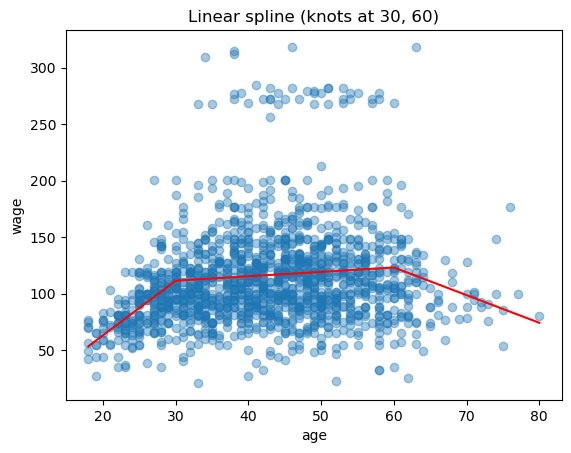

In [9]:
#Step 4: Graph the models
#Linear spline (knots = 30,60)
plt.scatter(wage_estimation['age'], wage_estimation['wage'], alpha=0.4, label='data') # Scatter plot of the observed data (age vs. wage)
plt.plot(age_grid, pred1_est, color='red', label='Linear spline (30,60)') # Plot the fitted spline line based on the predictions we did in step 2 and 3
plt.title('Linear spline (knots at 30, 60)') # Add plot title
plt.xlabel('age') # Add x-axis label
plt.ylabel('wage') # Add y-axis label

Text(0, 0.5, 'wage')

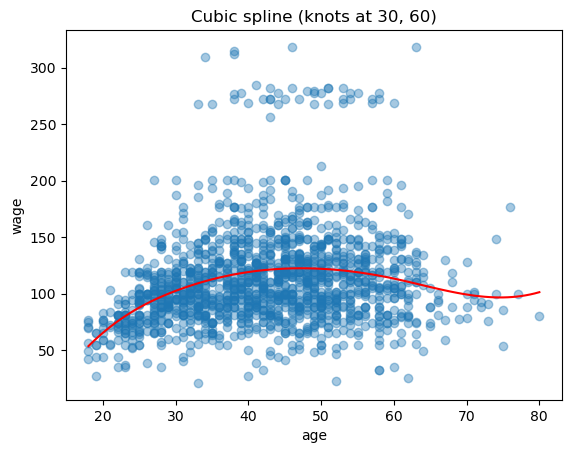

In [10]:
# Cubic spline (knots = 30,60)
plt.scatter(wage_estimation['age'], wage_estimation['wage'], alpha=0.4, label='data')
plt.plot(age_grid, pred2_est, color='red', label='Cubic spline (30,60)')
plt.title('Cubic spline (knots at 30, 60)')
plt.xlabel('age')
plt.ylabel('wage')

Text(0, 0.5, 'wage')

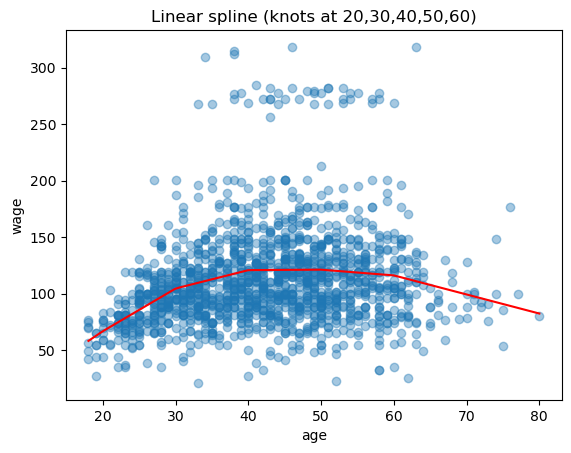

In [11]:
#Linear spline (knots = 20,30,40,50,60)
plt.scatter(wage_estimation['age'], wage_estimation['wage'], alpha=0.4, label='data')
plt.plot(age_grid, pred3_est, color='red', label='Linear spline (20–60)')
plt.title('Linear spline (knots at 20,30,40,50,60)')
plt.xlabel('age')
plt.ylabel('wage')

Text(0, 0.5, 'wage')

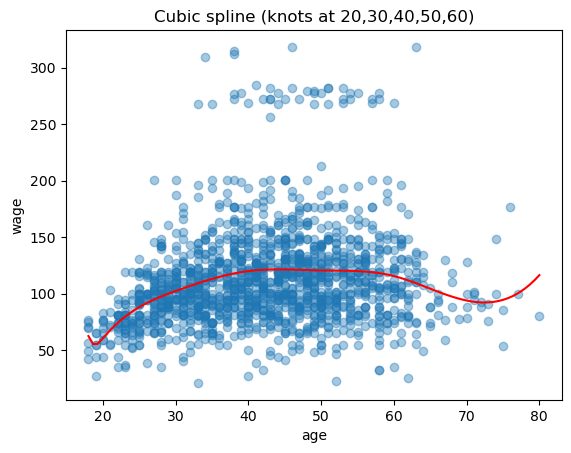

In [13]:
#Cubic spline (knots = 20,30,40,50,60)
plt.scatter(wage_estimation['age'], wage_estimation['wage'], alpha=0.4, label='data')
plt.plot(age_grid, pred4_est, color='red', label='Cubic spline (20–60)')
plt.title('Cubic spline (knots at 20,30,40,50,60)')
plt.xlabel('age')
plt.ylabel('wage')

In [14]:
# Step 5:Computing the test MSE
y_test = wage_testing['wage']
age_test = wage_testing['age']

In [15]:
# ---- Linear spline (knots at 30, 60) ----
# Build training design and fit the model (fit on training set only)
X1_train = pd.DataFrame({
    "const": 1,                     # intercept (statsmodels.OLS does NOT add it automatically)
    "age": age_est,
    "knot_30": np.maximum(0, age_est - 30),
    "knot_60": np.maximum(0, age_est - 60)
})
model1 = sm.OLS(y_est, X1_train).fit()   # fit on training data
print(model1.summary())

# Build test design (same transforms) and predict on test set
X1_test = pd.DataFrame({
    "const": 1,
    "age": age_test,
    "knot_30": np.maximum(0, age_test - 30),
    "knot_60": np.maximum(0, age_test - 60)
})
pred1_test = model1.predict(X1_test)                # predictions for each test observation


                            OLS Regression Results                            
Dep. Variable:                   wage   R-squared:                       0.085
Model:                            OLS   Adj. R-squared:                  0.083
Method:                 Least Squares   F-statistic:                     46.31
Date:                Mon, 20 Oct 2025   Prob (F-statistic):           1.28e-28
Time:                        16:21:18   Log-Likelihood:                -7681.2
No. Observations:                1500   AIC:                         1.537e+04
Df Residuals:                    1496   BIC:                         1.539e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -33.5173     16.015     -2.093      0.0

In [15]:
# Compute test MSE: average squared error on the test set for Linear spline (knots at 30, 60)
mse1 = ((y_test - pred1_test) ** 2).mean() # (1/n) * sum (y_i - yhat_i)^2
print("Linear (30,60) test MSE:", mse1)

Linear (30,60) test MSE: 1553.8066709872717


In [16]:
# Cubic spline (knots = 30,60)
X2_train = pd.DataFrame({
    "const": 1,
    "age": age_est, # linear term
    "age2": age_est**2, # quadratic term
    "age3": age_est**3, # cubic term
    "knot30": np.maximum(0, (age_est - 30)**3), #0 for age <= 30, (age-30)^3 for age>30
    "knot60": np.maximum(0, (age_est - 60)**3) #0 for age <= 60, (age-60)^3 for age>60
})
model2 = sm.OLS(y_est, X2_train).fit()
print(model2.summary())

# Build test design (same transforms) and predict on test set
X2_test = pd.DataFrame({
    "const": 1,
     "age": age_test, # linear term
    "age2": age_test**2, # quadratic term
    "age3": age_test**3, # cubic term
    "knot30": np.maximum(0, (age_test - 30)**3), #0 for age <= 30, (age-30)^3 for age>30
    "knot60": np.maximum(0, (age_test - 60)**3) #0 for age <= 60, (age-60)^3 for age>60
})
pred2_test = model2.predict(X2_test)                # predictions for each test observation



                            OLS Regression Results                            
Dep. Variable:                   wage   R-squared:                       0.093
Model:                            OLS   Adj. R-squared:                  0.090
Method:                 Least Squares   F-statistic:                     30.74
Date:                Mon, 20 Oct 2025   Prob (F-statistic):           7.62e-30
Time:                        16:21:24   Log-Likelihood:                -7674.4
No. Observations:                1500   AIC:                         1.536e+04
Df Residuals:                    1494   BIC:                         1.539e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -171.0164    243.459     -0.702      0.4

In [17]:
# Compute test MSE: average squared error on the test set for Cubic spline (knots = 30,60)
mse2 = ((y_test - pred2_test) ** 2).mean()
print("Cubic (30,60) test MSE:", mse2)

Cubic (30,60) test MSE: 1566.2653964426652


In [18]:
#Linear spline (knots = 20,30,40,50,60)
knots = [20, 30, 40, 50, 60]

# design matrix (intercept + age + hinge terms)
X3_train = pd.DataFrame({'const': 1, 'age': age_est})
for k in knots: #For each knot k we add the hinge (age - k)
    X3_train['knot' + str(k)] = np.maximum(0, age_est - k)  #0 for age <= k and age-k for age > k.

model3 = sm.OLS(y_est, X3_train).fit()
print(model3.summary())

# ---- Predict on the test set (must use same transforms) ----
X3_test = pd.DataFrame({'const': 1, 'age': age_test})
for k in knots:
    X3_test['knot' + str(k)] = np.maximum(0, age_test - k)

pred3_test = model3_est.predict(X3_test)   # one prediction per test observation

                            OLS Regression Results                            
Dep. Variable:                   wage   R-squared:                       0.093
Model:                            OLS   Adj. R-squared:                  0.089
Method:                 Least Squares   F-statistic:                     25.52
Date:                Mon, 20 Oct 2025   Prob (F-statistic):           5.57e-29
Time:                        16:21:33   Log-Likelihood:                -7674.6
No. Observations:                1500   AIC:                         1.536e+04
Df Residuals:                    1493   BIC:                         1.540e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -19.8389    151.821     -0.131      0.8

In [19]:
# Compute test MSE: average squared error on the test set for Linear Spline (20,30,40,50,60)
mse3 = ((y_test - pred3_test) ** 2).mean()
print("Linear Spline (20,30,40,50,60) test MSE:", mse3)

Linear Spline (20,30,40,50,60) test MSE: 1557.8265245010666


In [20]:
#Cubic spline (knots = 20,30,40,50,60)
knots = [20, 30, 40, 50, 60]

X4_train = pd.DataFrame({
    'const': 1,
    'age': age_est,
    'age2': age_est**2,
    'age3': age_est**3
})
for k in knots:
    X4_train['knot' + str(k)] = np.maximum(0, (age_est - k)**3) #0 for age <= k, and (age-k)^3 for age > k

model4_est = sm.OLS(y_est, X4_train).fit()
print(model4_est.summary())

# ---- Predict on the test set (same transforms) ----
X4_test = pd.DataFrame({
    'const': 1,
    'age': age_test,
    'age2': age_test**2,
    'age3': age_test**3
})
for k in knots:
    X4_test['knot' + str(k)] = np.maximum(0, (age_test - k)**3)

pred4_test = model4_est.predict(X4_test)   # predictions for each test observation


                            OLS Regression Results                            
Dep. Variable:                   wage   R-squared:                       0.094
Model:                            OLS   Adj. R-squared:                  0.090
Method:                 Least Squares   F-statistic:                     19.44
Date:                Mon, 20 Oct 2025   Prob (F-statistic):           4.63e-28
Time:                        16:21:38   Log-Likelihood:                -7673.4
No. Observations:                1500   AIC:                         1.536e+04
Df Residuals:                    1491   BIC:                         1.541e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.899e+04   2.39e+04      0.795      0.4

In [21]:
# Compute test MSE for Cubic knots 20,30,40,50,60
mse4 = ((y_test - pred4_test) ** 2).mean()   
print("Test MSE (Cubic knots 20,30,40,50,60):", mse4)

Test MSE (Cubic knots 20,30,40,50,60): 1563.1961725294118
